In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

Initial image

In [5]:
# Create a data frame to store the dataset and use number to represent a class
def initImg(root, matrix_label):
    label_lst, class_lst, img_lst = [], [], []
    label = 0
    for file in os.listdir(root):
        class_path = os.path.join(root, file)
        for fn in os.listdir(class_path):
            img_path = os.path.join(class_path, fn)
            img_lst.append(img_path)
            class_lst.append(file)
            if file not in matrix_label:
                matrix_label.append(file)
            label_lst.append(label)
        label += 1

    return pd.DataFrame({
        "filename": img_lst,
        "class": class_lst,
        "label": label_lst
    })

Feature Extraction Utilities

- SIFT

In [6]:
# preprocess the dataset and get descriptors for each image and build histogram
def preprocessImg(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    sharpened = cv2.addWeighted(img, 1, laplacian, 1.0, 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(sharpened)
    return clahe_img


def build_bow_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)

    descriptors = np.asarray(descriptors, dtype=np.float32)
    words = kmeans.predict(descriptors)

    histogram, _ = np.histogram(words, bins=np.arange(n_clusters + 1))

    return histogram


def get_descriptors(img_path, preprocess=True):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if preprocess:
        gray = preprocessImg(gray)

    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)

    return descriptors


def descriptorlst(train_df):
    descriptor_lst = []

    for _, row in train_df.iterrows():
        descriptors = get_descriptors(row['filename'], preprocess=True)
        if descriptors is not None:
            descriptor_lst.extend(descriptors)
    descriptor_lst = np.asarray(descriptor_lst, dtype=np.float32)

    return descriptor_lst

- LBP

In [7]:
radius = 1
n_points = 8 * radius
method = 'uniform'

def extract_lbp_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method).astype(np.uint8)

    hist = cv2.calcHist([lbp], [0], None, [n_points + 2], [0, n_points + 2])
    hist = cv2.normalize(hist, hist).flatten()

    return hist

Dataloader

In [8]:
def dataloader(data, preprocess):
    train_index = np.load('train_indices.npy')
    test_index = np.load('val_indices.npy')
    train_df, test_df = data.iloc[train_index], data.iloc[test_index]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    if preprocess == 'sift':
        descriptor_lst = descriptorlst(train_df)
        kmeans = MiniBatchKMeans(n_clusters=100, random_state=42)
        kmeans.fit(descriptor_lst)
        for df, X, y in [(train_df, X_train, y_train), (test_df, X_test, y_test)]:
            for _, row in df.iterrows():
                descriptors = get_descriptors(row['filename'], preprocess=False)
                hist = build_bow_histogram(descriptors, kmeans, 100)
                X.append(hist)
                y.append(row['label'])

    elif preprocess == 'lbp':
         for df, X, y in [(train_df, X_train, y_train), (test_df, X_test, y_test)]:
            for _, row in df.iterrows():
                features = extract_lbp_features(row['filename'])
                X.append(features)
                y.append(row['label'])

    return np.array(X_train), y_train, np.array(X_test), y_test

Model Training and Evaluation

In [11]:
def evaluate_model(model, X_test, y_test, matrix_lst):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_lst, yticklabels=matrix_lst)
    plt.show()


=== Results for SIFT Features ===

-- Logistic Regression --


c:\Users\z5527155\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6291666666666667
Precision: 0.6271883942941774
Recall: 0.6280227164855461
F1 Score: 0.6263410509429609


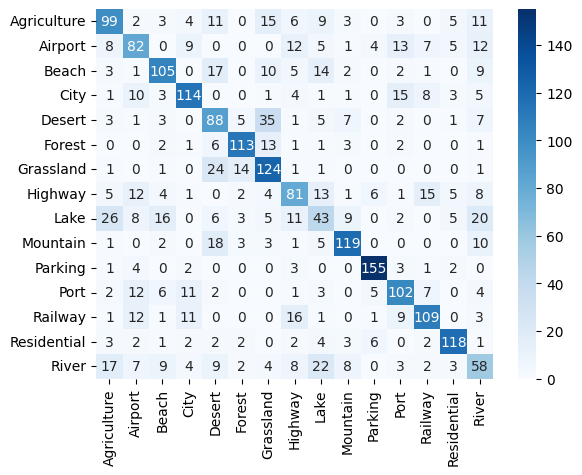


-- KNN --
Accuracy: 0.5641666666666667
Precision: 0.5729070761966021
Recall: 0.564615491469098
F1 Score: 0.5588661234429774


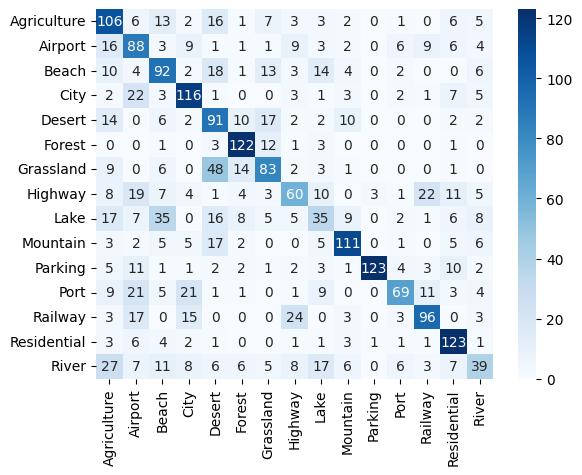


=== Results for LBP Features ===

-- Logistic Regression --
Accuracy: 0.4125
Precision: 0.39568777385801407
Recall: 0.41518011417788
F1 Score: 0.38581537886879913


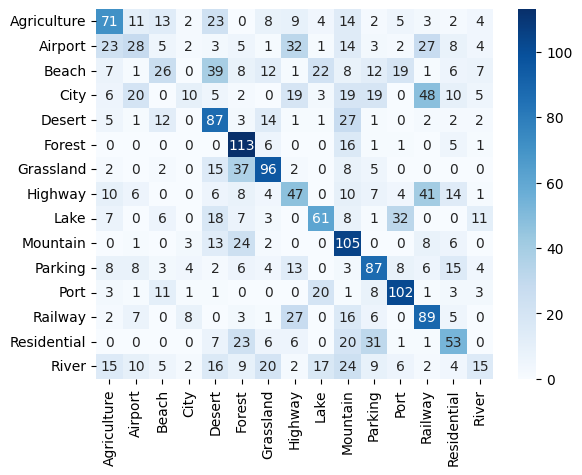


-- KNN --
Accuracy: 0.5141666666666667
Precision: 0.5212039198947607
Recall: 0.517790549720318
F1 Score: 0.5140495582401213


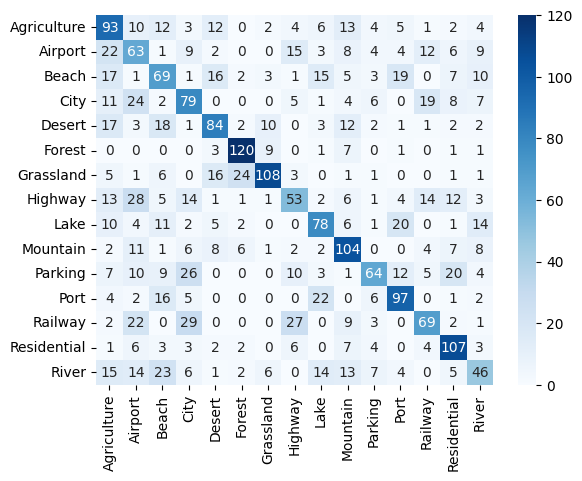

In [13]:
def run_models(X_train, y_train, X_test, y_test, descriptor_name, matrix_lst):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }

    print(f"\n=== Results for {descriptor_name.upper()} Features ===")
    for model_name, model in models.items():
        print(f"\n-- {model_name} --")
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, matrix_lst)


# Initialize dataset
root_dir = 'Aerial_Landscapes'
matrix_label = []
df = initImg(root_dir, matrix_label)

# Run for both SIFT and LBP
for descriptor_type in ['sift', 'lbp']:
    X_train, y_train, X_test, y_test = dataloader(df, preprocess=descriptor_type)
    run_models(X_train, y_train, X_test, y_test, descriptor_type, matrix_label)
